In this article, we'll have a look at a typical workflow for a simple nonlinear binary classification problem. We'll keep things simple.

There are four major steps to follow during a machine learning process:

1. Data preparation
2. Model building
3. Model training
4. Model evaluation

And now, without further ado, let's jump right in and start at the first step.

# Data Preparation

Let's import the stuff we need to work with:

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

## Creating Data

We'll use a method from `sklearn.datasets` to create some data:

In [ ]:
from sklearn.datasets import make_moons

# 1000 samples will do.
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

Let's view some samples:

In [ ]:
X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

Let's check out the shapes:

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

As we can see, there are 1000 records. This is what the first dimension tells us. The second dimension for X means it has 2 features (vector) whereas y has a single feature (scalar). We have 2 inputs for 1 output.

## Data Visualization

Let's first see the data in a more readable tabular form:

In [ ]:
moons = pd.DataFrame(X, columns=["X1", "X2"])
moons['label'] = y
moons.head()

,X1,X2,label
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0


As this is binary classification, there should be just two labels, 0 and 1. Let's make sure:

In [ ]:
moons.label.value_counts()

,count
label,
1,500
0,500


Looks like we have a well-balanced set with two labels. Let's plot the data:

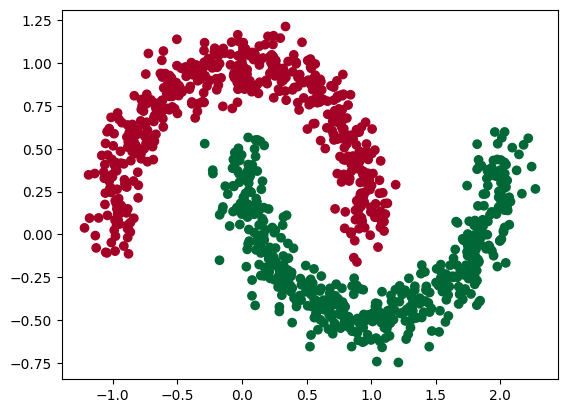

In [ ]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlGn)

As you can see, this data is nonlinear, so we won't be able to find a straight line that separates the data belonging to the two classes. This is why we're going to use a nonlinear model.

## Tensors

PyTorch works with tensors, so we have to turn our data into tensors:

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Let's view some samples.
X[:5], y[:5]

(tensor([[-0.0515,  0.4442],
         [ 1.0320, -0.4197],
         [ 0.8679, -0.2548],
         [ 0.2889, -0.4487],
         [-0.8334,  0.5351]]),
 tensor([1., 1., 1., 1., 0.]))

We have tensors, we're good to go.

## Training Set and Test Set

Before we build our model, we should split the data into two separate sets, a training set and a test set:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

We have 800 training samples and 200 testing samples. Now we can start building the model.



# Model Building

We have the data in place, it's time to build a model. Besides the model, we'll define a loss function and optimizer.

But before that, let's make our code device agnostic. This is not strictly necessary for such a small dataset as ours, but it's good practice. This way, we'll make use of GPU if it's available, otherwise we'll make use of CPU:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In Google Colab, we can change the runtime to GPU in the Runtime menu under Change runtime type. We're not going to do it here, though.

## Defining the Model

We now want to build a model that will take our inputs and produce outputs similar to our current outputs. In other words, given the features, the model will predict the labels.

There are a couple ways of approaching this in PyTorch, but we'll create the model as a class. If we create a model as a class, we almost always inherit from `nn.Module`. Then, inside the `__init__` method, we create the layers of the neural network. In our case, we need both linear and nonlinear layers. We'll use the ReLU activation function for the latter.

It's up to us how many layers we create. It depends on how much space we want to give the model to learn. In any case, we pass two arguments to the `nn.Linear` method: `in_features`, set to the number of inputs in a particular layer, and `out_features`, set to the number of outputs from a particular layer. We can set these arguments to any numbers we want. We just have to follow the following rules:

- In the first layer, we set `in_features` to the number of inputs to the model.
- In the last layer, we set `out_features` to the number of outputs from the model.
- In the hidden layers (the layers between the first and last layers), the number if `in_features` must be equal to the number of `out_features` in the preceding layer.

We also have to define a `forward` method, which will contain the forward pass computation of the model.

In order to inherit from `nn.Module` and create the layers of the neural network, we have to import `nn`:

In [ ]:
from torch import nn

And now, let's build the model:

In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Here we create three linear layers. We have 2 inputs for 1 output. We'll also create a hidden layer.
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=5)
        self.layer_3 = nn.Linear(in_features=5, out_features=1)

        # here's the nonlinear layer
        self.relu = nn.ReLU()

    # Here we define the method that will compute the forward pass.
    def forward(self, x):
        # The computation will go through three linear layers and the nonlinear ones between them.
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In the model class, we define a hidden layer with 5 hidden units. This way, the model will learn patterns from 5 numbers, not just the two. This may result in better outputs. We could use a higher number, but our dataset is pretty simple, so let's stick with 5.

Let's create an instance of the model and send it to the target device:

In [ ]:
model = BinaryClassificationModel().to(device)
model

BinaryClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

## Loss Function and Optimizer

The loss function is used to measure how wrong your model's predictions are compared to the truth labels (the labels in the y_test set).

The optimizer instructs your model to update its internal parameters to lower the loss.

There are a lot of loss functions in PyTorch we can choose from. For binary classification, a common choice is BCE (Binary Cross Entropy), which we're going to use. To this end, we'll use the `torch.nn.BCEWithLogitsLoss` method. This method calculates loss using logits (the raw output from the model).

There are also a lot of optimizers. Some common ones are Adam and SGD (stochastic gradient descent). Let's pick SGD. In order to do that, we'll use the `torch.optim.SGD` method.

The SGD optimizer takes two parameters:

- `params` - these are the model's parameters that we want to optimize,
- `lr` - this is the learning rate - the higher it is the faster the optimizer will update the parameters.

We must be careful with the learning rate. It should be neither too high nor too low or it will fail to work.

So, here are the loss function and the optimizer:

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Metrics

We'll evaluate our model using just one metric, accuracy. It's calculated as the total number of correct predictions divided by the total number of predictions. Let's define a function that will calculate accuracy for us:

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Model Training

Training the model involves two loops: a training loop, where the model learns the relationships between the features and labels, and a testing loop, where the model is evaluated. Let's see what exactly each of the loops contains.

## Training Loop

As mentioned above, in the training loop, the model goes through the training data and learns how the features are related to the labels.

The steps inside a training loop contain:

1. Forward pass - the model performs the `forward` method on all training data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. Gradient zeroing - the optimizer's gradients are set to zero (by default, they're accumulated) so that they can be calculated from scratch for this step,
4. Backpropagation - the gradient of the loss with respect to each parameter with `requires_grad` set to `True` is calculated,
5. Gradient descent - the parameters are updated.

## Testing Loop

The testing loop consists of the following steps:

1. Forward pass - the model performs the `forward` method on all testing data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. (optionally) Evaluation metrics - we can calculate metrics like accuracy, precision or recall on the test set; we're not going to do it here.

## Training the Model

Now, let's implement all these steps in the training and testing loops:

In [ ]:
# seed for reprodicibility of random values
torch.manual_seed(42)

# Train for 1000 epochs.
epochs = 1000

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training loop

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Loss and accuracy calculation
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Gradient zeroing
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing loop

    # Put the model in evaluation mode.
    model.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Loss and accuracy calculation
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out information every hundredth epoch
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70584, Accuracy: 50.00% | Test loss: 0.70233, Test acc: 50.00%
Epoch: 100 | Loss: 0.30488, Accuracy: 85.75% | Test loss: 0.31492, Test acc: 84.00%
Epoch: 200 | Loss: 0.25679, Accuracy: 87.62% | Test loss: 0.25454, Test acc: 88.00%
Epoch: 300 | Loss: 0.25191, Accuracy: 88.12% | Test loss: 0.24681, Test acc: 88.00%
Epoch: 400 | Loss: 0.24884, Accuracy: 88.25% | Test loss: 0.24350, Test acc: 88.50%
Epoch: 500 | Loss: 0.24513, Accuracy: 88.62% | Test loss: 0.24006, Test acc: 90.00%
Epoch: 600 | Loss: 0.23991, Accuracy: 88.88% | Test loss: 0.23552, Test acc: 90.00%
Epoch: 700 | Loss: 0.23353, Accuracy: 89.12% | Test loss: 0.23011, Test acc: 89.50%
Epoch: 800 | Loss: 0.22718, Accuracy: 89.50% | Test loss: 0.22515, Test acc: 89.50%
Epoch: 900 | Loss: 0.22223, Accuracy: 89.88% | Test loss: 0.22145, Test acc: 89.50%


Looks like the loss is decreasing and accuracy is increasing, which is good.

# Model Evaluation

Let's evaluate the model and see how it performs on data it never saw:

In [ ]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

Let's see how the test data and the predictions compare:

In [ ]:
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

Or, even better, let's plot it. To do it, we'll use a function that we are going to download from an external Github repository. This function will enable us to plot a decision boundary. It was created by Daniel Bourke and we're going to download it from his repo, which is available at https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py.

In [ ]:
import requests
from pathlib import Path

if not Path("helper_functions.py").is_file():
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

The code snippet above downloads the **helper_functions.py** file. Now we can use the function we're interested in:

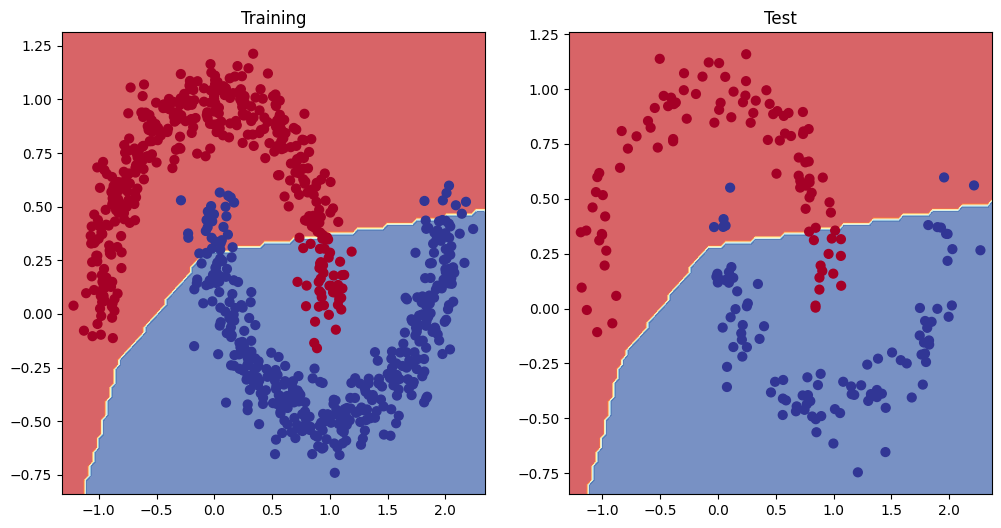

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

As we can see, the model classifies most of the test data correctly, although it's not perfect and there's definitely room for improvement.

# Conclusion

The model we created performs pretty well. It's not perfect and we could fine-tune it for better results. Although most of the test data is classified correctly, some of it isn't. One thing we could try is train it for more epochs. Feel free to give it a try.